# Aktuelle Limitierungen:

* Inhalte, die mehreren Fächern zugeordnet worden sind, zählen nur zu einem Fach
* Es werden nur Bearbeitungen gezählt
* Folgeevents einer Bearbeitung werden nicht zusammengefasst

In [26]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown, HTML

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

display(getSubjectFromUuid(127338))
display(getSubjectFromUuid(63496))
display(getSubjectFromUuid(1))

'Chemie'

'Chemie'

None

In [75]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(10)

,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
252189,95849,2019-01-02 11:53:00,hernlmax,127428,Chemie
252194,95849,2019-01-02 11:54:28,hernlmax,127428,Chemie
252196,95849,2019-01-02 11:56:19,hernlmax,127355,Chemie
252198,95849,2019-01-02 12:12:57,hernlmax,127432,Chemie


In [89]:
import matplotlib.pyplot as plt

def show(subject=None, lower=10, time_interval=90):
    df = event_log.copy()
    
    if subject:
        df = df[df["subject"] == subject]
        if len(df) == 0:
            return
        
    df = compute_edits_per_day_per_user(df)
    df = df.rolling(time_interval, min_periods=time_interval).sum()
    df.dropna(inplace=True)
    
    display(Markdown(f"### Plot Anzahl Autor:innen mit Edits >= {lower}"))
    df.apply(lambda x: x.map(lambda y: y >= lower).sum(), axis=1).plot(figsize=(10,10))
    plt.show()
    
    df2 = pd.DataFrame({
        "edits": df.loc[df.index[-1]],
        "edits_before": df.loc[df.index[-1-time_interval]],
    })
    
    count = (df2["edits"] >= lower).sum()
    
    display(Markdown(f"Anzahl Autor:innen mit Edits >= {lower}: {count}"))
    
    display(Markdown(f"### Autor:innen mit Edits >= {lower}"))
    d = df2[df2["edits"] >= lower][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Autor:innen mit Edits < {lower} und vorher Edits >= {lower}"))
    d = df2[(df2["edits"] < lower) & (df2["edits_before"] >= lower)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    

def compute_edits_per_day_per_user(df, since=4*365.25):
    current_date = df["date"].max()
    df = df[df["date"] > current_date - pd.Timedelta(days=since)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

### Plot Anzahl Autor:innen mit Edits >= 10

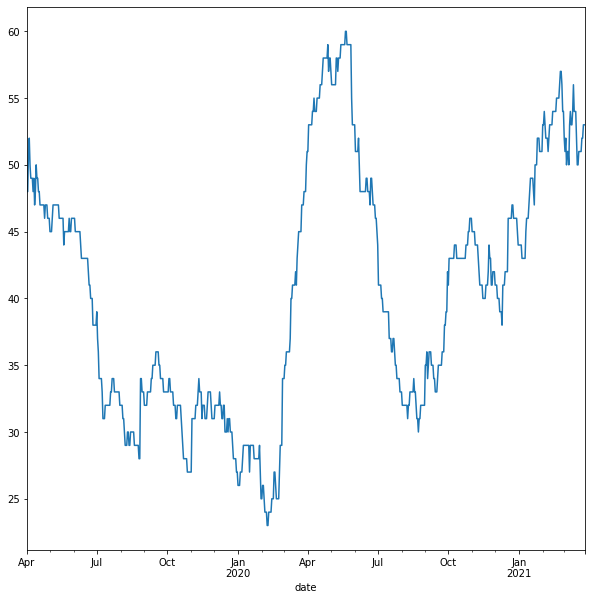

Anzahl Autor:innen mit Edits >= 10: 53

### Autor:innen mit Edits >= 10

,edits
WandaPaetzold,1351.0
kathongi,935.0
LinaMaria,690.0
Annika-Hemlein,458.0
Kowalsky,455.0
HannaKulke,418.0
Katrin_K,325.0
Karin,302.0
MarK97,290.0
dal,223.0


### Autor:innen mit Edits < 10 und vorher Edits >= 10

,edits
michi_,9.0
Kulla,9.0
03gymnasium_rahden,8.0
Renate,6.0
10gymnasium_rahden,5.0
07gymnasium_rahden,5.0
04gymnasium_rahden,4.0
02gymnasium_rahden,3.0
05gymnasium_rahden,2.0
ClaudiaR,1.0


In [90]:
show()

### Plot Anzahl Autor:innen mit Edits >= 100

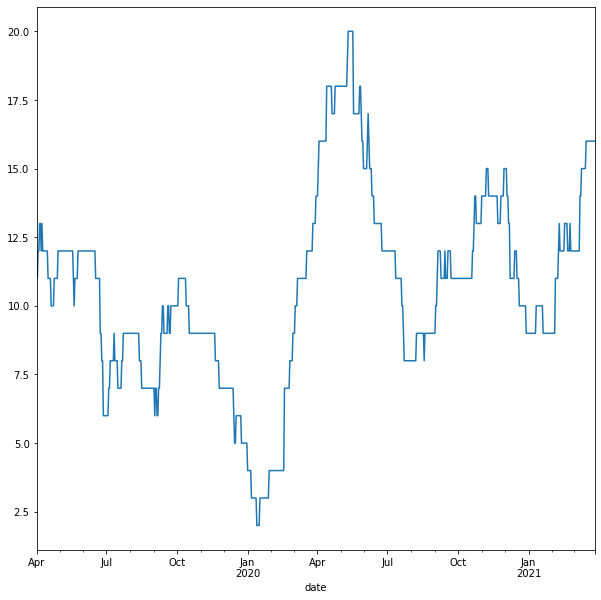

Anzahl Autor:innen mit Edits >= 100: 16

### Autor:innen mit Edits >= 100

,edits
WandaPaetzold,1351.0
kathongi,935.0
LinaMaria,690.0
Annika-Hemlein,458.0
Kowalsky,455.0
HannaKulke,418.0
Katrin_K,325.0
Karin,302.0
MarK97,290.0
dal,223.0


### Autor:innen mit Edits < 100 und vorher Edits >= 100

,edits
Madlen,86.0
PaulMusikus,0.0


In [91]:
show(lower=100)

### Plot Anzahl Autor:innen mit Edits >= 50

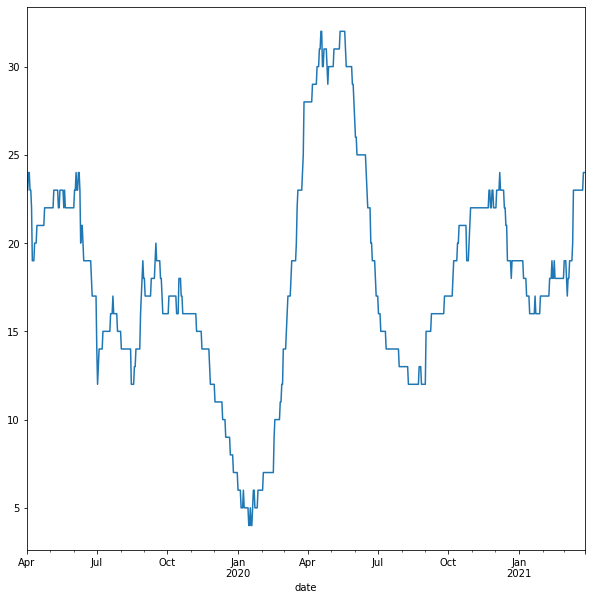

Anzahl Autor:innen mit Edits >= 50: 24

### Autor:innen mit Edits >= 50

,edits
WandaPaetzold,1351.0
kathongi,935.0
LinaMaria,690.0
Annika-Hemlein,458.0
Kowalsky,455.0
HannaKulke,418.0
Katrin_K,325.0
Karin,302.0
MarK97,290.0
dal,223.0


### Autor:innen mit Edits < 50 und vorher Edits >= 50

,edits
Theresa_Rudolph,39.0
wolfgang,31.0
MGoeldner,22.0
Marc_Ho,19.0
Taulant-Osmani,0.0
PaulMusikus,0.0


In [92]:
show(lower=50)

In [98]:
event_log["subject"].unique()

array(['Chemie', None, 'Mathe', 'Community', 'Englisch', 'Nachhaltigkeit',
       'Physik', 'Lerntipps', 'Informatik',
       'Deutsch als Zweit- und Fremdsprache', 'Biologie', 'Kommunikation',
       'Rechnungswesen', 'Geschichte', 'Psychologie', 'Wirtschaft',
       'Politik', 'mathÃ©matiques', 'Geographie',
       'à®‡à®²à®•à¯\x8dà®•à®£à®®à¯\x8d', 'Medienbildung', 'Testbereich',
       'Latein', 'à®µà®°à®²à®¾à®±à¯\x81', 'Deutsch als Fremdsprache',
       'MatemÃ¡ticas', 'Conseils pour apprendre', 'Sex Education',
       'Musik', 'Forensik', 'Italienisch'], dtype=object)

## Fach: Mathe

### Plot Anzahl Autor:innen mit Edits >= 10

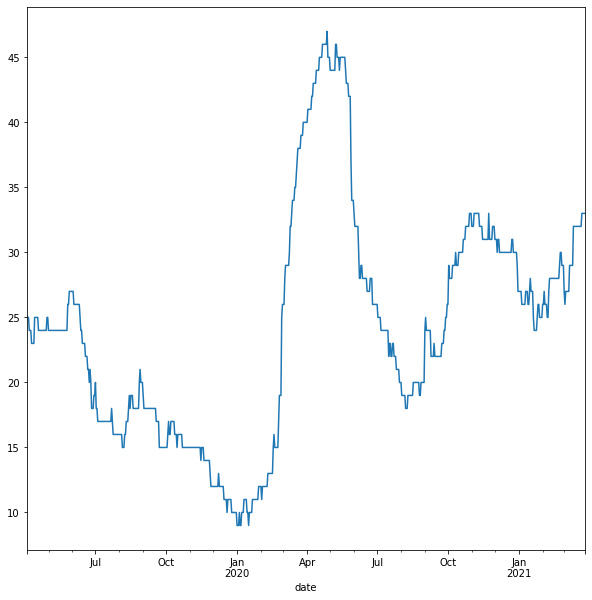

Anzahl Autor:innen mit Edits >= 10: 33

### Autor:innen mit Edits >= 10

,edits
WandaPaetzold,1263.0
kathongi,915.0
HannaKulke,418.0
Kowalsky,414.0
Annika-Hemlein,352.0
MarK97,288.0
Katrin_K,285.0
Karin,274.0
dal,191.0
Mathewally,138.0


### Autor:innen mit Edits < 10 und vorher Edits >= 10

,edits
michi_,9.0
Renate,4.0
ClaudiaR,0.0
dems15v1,0.0
anne22,0.0
gruenerBogen,0.0
hp,0.0
annak,0.0
isabellad,0.0
Carolin,0.0


## Fach: Chemie

### Plot Anzahl Autor:innen mit Edits >= 10

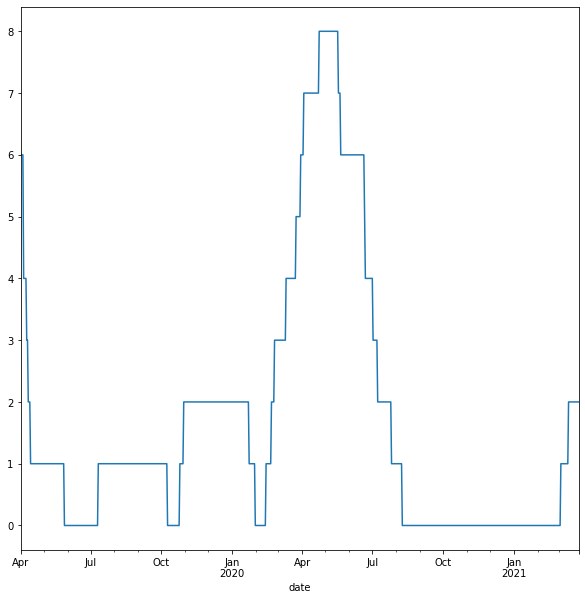

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit Edits >= 10

,edits
WandaPaetzold,33.0
Rubikscube,13.0


### Autor:innen mit Edits < 10 und vorher Edits >= 10

,edits


## Fach: Physik

### Plot Anzahl Autor:innen mit Edits >= 10

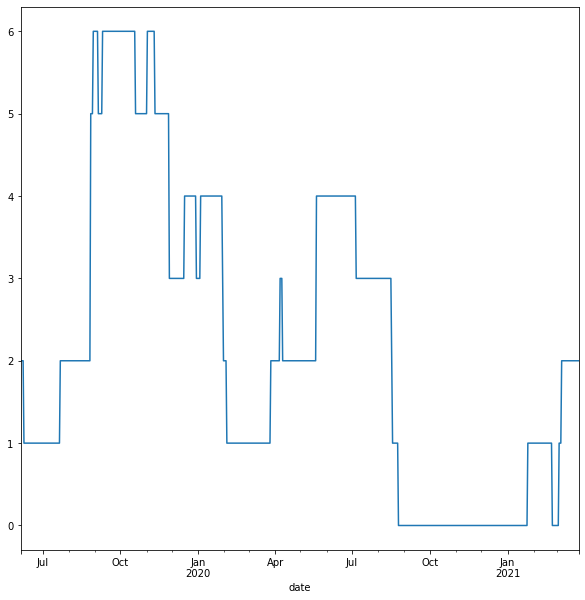

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit Edits >= 10

,edits
Matheo,28.0
Kowalsky,10.0


### Autor:innen mit Edits < 10 und vorher Edits >= 10

,edits


## Fach: Nachhaltigkeit

### Plot Anzahl Autor:innen mit Edits >= 10

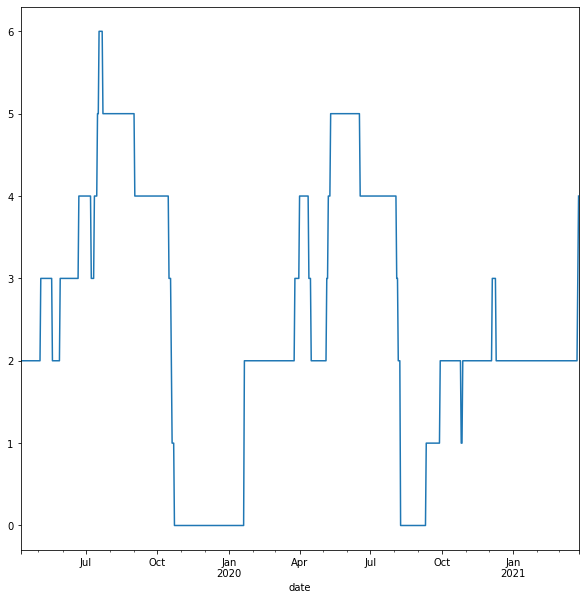

Anzahl Autor:innen mit Edits >= 10: 4

### Autor:innen mit Edits >= 10

,edits
Gesine,68.0
Nanami,18.0
WandaPaetzold,16.0
Corinna,11.0


### Autor:innen mit Edits < 10 und vorher Edits >= 10

,edits


## Fach: Biologie

### Plot Anzahl Autor:innen mit Edits >= 10

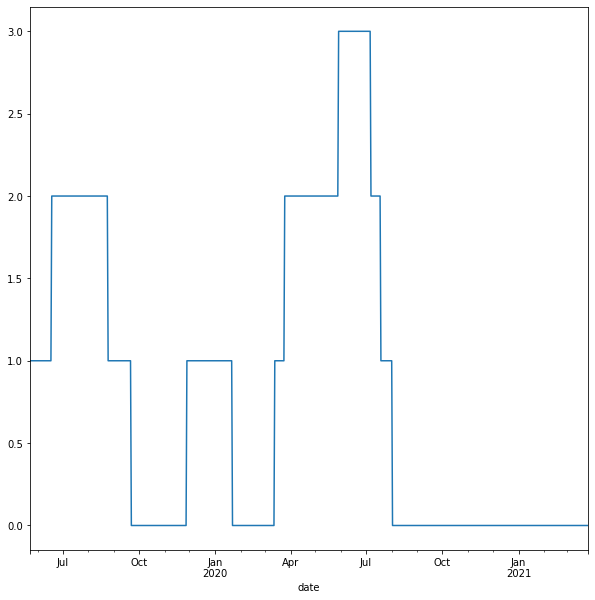

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit Edits >= 10

,edits


### Autor:innen mit Edits < 10 und vorher Edits >= 10

,edits


In [99]:
for subject in ["Mathe", "Chemie", "Physik",
                  "Nachhaltigkeit", "Biologie"]:
    
    display(Markdown(f"## Fach: {subject}"))
    show(subject=subject)